# <center> R1.04 Méthodes d'optimisation <br> TP3a - Interpolation polynomiale : Introduction </center>
<center> 2022/2023 - Thibault Godin & Lucie Naert </center>
<center> IUT de Vannes, BUT Informatique </center>

Le but de ce TP est d'apprehénder le concept d'interpolation polynomiale.
Le TP suivant sera consacré à une application, le _partage de secres_



In [2]:
import numpy as np

# Affichage graphique

#%matplotlib notebook 
# enable interactivity of plots
# attention a bien fermer les fenetres plt après chaque visualisalisation

%matplotlib inline


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors

names_col = list(mcolors.XKCD_COLORS)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']


import time



##### L'idée de base derière l'interpolation est la suivante :

on observe $n$ points $(x_1,y_1), ..., (x_n,y_n)$ de $\mathbb{R}^2$ ;

on suppose que ces points représentent les observation d'une fonction (inconnue) $f : \mathbb{R} \to \mathbb{R}$


On souhaite approcher $f$ par un polynôme de degré max $n-1$. 

Ce degré est le plus bas possible, en effet on a  


<div class="alert alert-block alert-info"><b>Théorème</b> 
Soient $n$ points de points de $\mathbb{R}^2$ $(x_1,y_1), ..., (x_n,y_n)$

    
Alors il existe un unique polynôme de degré $n-1$ $P_{(x_1,y_1), ..., (x_n,y_n)}$ tel que $P_{(x_1,y_1), ..., (x_n,y_n)}(x_i) = y_i$ pour tout $0 \le i\le n$
   
</div>

Ce théorème est la généralisation du principe que vous connaissez depuis le collège : il existe une unique droite (polynôme de degré 1) passant par 2 points donnés.



Dans toute la suite du TP on considère que les points $(x_1,y_1), ..., (x_n,y_n)$ sont fixés

[0, 2, 3, 4, 4.5] [  6.           1.92506768 -14.88453084 -30.68773248 -13.97523315]


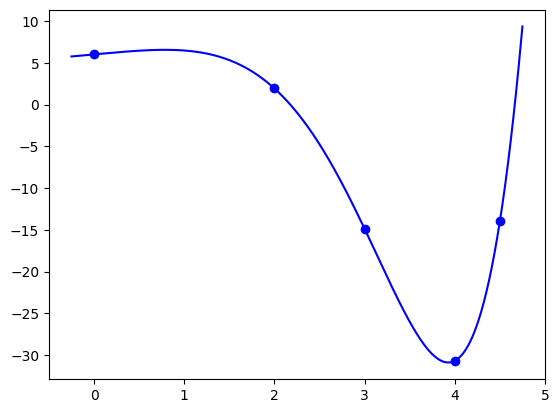

In [3]:
def f(x):
    resurn np.exp(x)*np.cos(x)+5

###Données
X=[0,2,3,4,4.5]
Y=f(X)

print(X,Y)

#tracé
xcont=np.linspace(-.25,4.75,500)
ycont=f(xcont)

plt.plot(xcont,ycont, color='blue')
plt.scatter(X,Y, color='blue')

## Polynomes de Lagrange


Posons 

$l_i(x) = y_i \times \prod_{j=0, j\neq i}^n\frac{x-x_j}{x_i-x_j} = y_i \times \frac{x-x_0}{x_i-x_0} \cdots \frac{x-x_{i-1}}{x_i-x_{i-1}} ~ \frac{x-x_{i+1}}{x_i-x_{i+1}} \cdots \frac{x-x_n}{x_i-x_n} $

le $i$ème  polynôme de Lagrange et

$L(x)=\sum_i l_i(x) = l_1(x) + l_2(x) + \cdots + l_n(x)$


**question 1**
Calculer $l_1(x_1)$ et $l_1(x_2)$. Généraliser à $l_i(x_j)$



l1(x1) = y1 * ( ((x1 - x0) / (x1 - x0)) * ((x1 - x2) / (x1 - x1)) ) = y1
l1(x2) = y1 * ( ((x2 - x0) / (x1 - x0)) * ((x2 - x2) / (x1 - x2)) ) = 0

li(xj) = yi * ( ((xj - x0) / (xi - x0)) * ((xj - xj) / (xi - xj)) )


**question 2**

1. Définir une fonction `pol_li(varX,i,X,Y)` qui calcule $l_i(varX)$ sachant que `X` est le vecteur des $x_i$ et `Y` le vecteur des $y_i$ 
1. Définir une fonction `pol_Lagrange(varX,X,Y)` qui calcule $L(varX)$

In [4]:
def pol_li(varX,i,X,Y):
    sum = 1

    for j in range(0, len(X)):
        if j != i:
            sum *= (varX - X[j]) / (X[i] - X[j])
    
    return (Y[i] * sum)

def pol_Lagrange(varX,X,Y):
    res = 0

    for i in range(1, len(X)):
        res += pol_li(varX, i, X, Y)
    
    return (res)

print(pol_li(X[0],0,X,Y),pol_li(X[1],0,X,Y))

6.0 -0.0


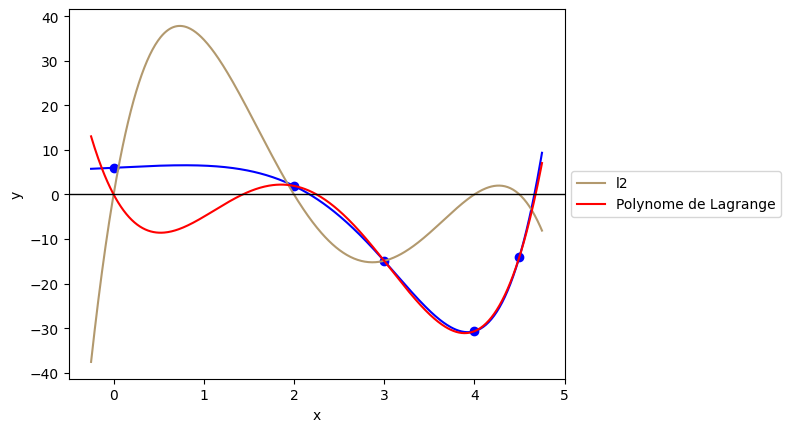

In [5]:
#tracé
plt.plot(xcont,ycont, color='blue')
plt.scatter(X,Y, color='blue')
n=len(X)

#for i in range(n):
#    legend = "l" +str(i)
#    plt.plot(xcont,pol_li(xcont,i,X,Y), label = legend, color=names_col[i])

i = 2
legend = "l" +str(i)
plt.plot(xcont,pol_li(xcont,i,X,Y), label = legend,color=names_col[i])    
plt.plot(xcont,pol_Lagrange(xcont,X,Y), label = "Polynome de Lagrange", color='red')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.axhline(y=0, color='k', linewidth = 1)
plt.show()

## Algorithme de Newton

La fonction retournant le polynôme de Lagrange que nous venons d'implémenter possède un défaut : si on rajoute un point à nos données, on doit tout recalculer. Si on a de nombreuses données évoluant au cours du temps, c'est un problème

On va donc constuire ce polynôme d'une autre façon, recursivement à l'aide des différences divisées.

Le polynôme d'interpolation de Newton $N(x)$
associé à $k$ points $(x_1, y_1),\ldots,(x_k, y_k)$ est défini par :


$$N(x)=[y_1]+[y_1,y_2]n_1(x)+\ldots+[y_1,\ldots,y_k]n_{k-1}(x)$$

Avec $n_j(x)$ le $j$-ème polynôme de Newton : $n_j(x)=\prod_{1\le i<j}(x-x_i)$ 

et $[y_1,...,y_j]$ les différences divisées, définies récursivement par
$\begin{cases}
[y_{\alpha}] &= y_{\alpha} \\
[y_{\alpha},\ldots,y_{\alpha+j}] &= \frac{[y_{\alpha+1},\ldots y_{\alpha+j}] - [y_{\alpha},\ldots y_{\alpha+j-1}]}{x_{\alpha+j}-x_{\alpha}}
\end{cases}$


**question 3**

1. Implémenter la fonction `pol_ni(varX,i,X,Y)` donnant le $i$-ème polynôme de Newton $n_i(varX)$.

2. Implémenter la fonction `diffdiv(X,Y,i)` donnant la différence divisée $[y_1,...,y_{1+i}]$

[0, 2, 3, 4, 4.5] [  6.           1.92506768 -14.88453084 -30.68773248 -13.97523315]
-4.924044121062649
-4.924044121062649


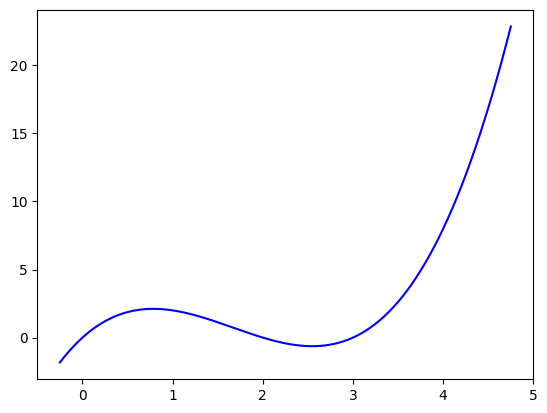

In [7]:
def pol_ni(varX, i, X, Y):
    res = 1

    for j in range(i):
        res = res * (varX-X[j])
    return (res)


def diffdiv(X, Y, i):
    return (Y[0] if i == 0 else (diffdiv(X[1:], Y[1:], i-1) - diffdiv(X[:-1], Y[:-1], i-1)) / (X[i] - X[0]))

print(X, Y)
a = (Y[1]-Y[0]) / (X[1]-X[0])
b = (Y[2]-Y[1]) / (X[2]-X[1])

print((b-a)/(X[2]-X[0]))
print(diffdiv(X, Y, 2))

plt.plot(xcont, pol_ni(xcont, 3, X, Y), color='blue')  # -4,82


    
    
**question 4**
1. Ecrire une fonction `pol_Newton(varX,X,Y)` qui calcule le polynôme de Newton 
2. Observer graphiquement les résultats de l'interpolation.  
    

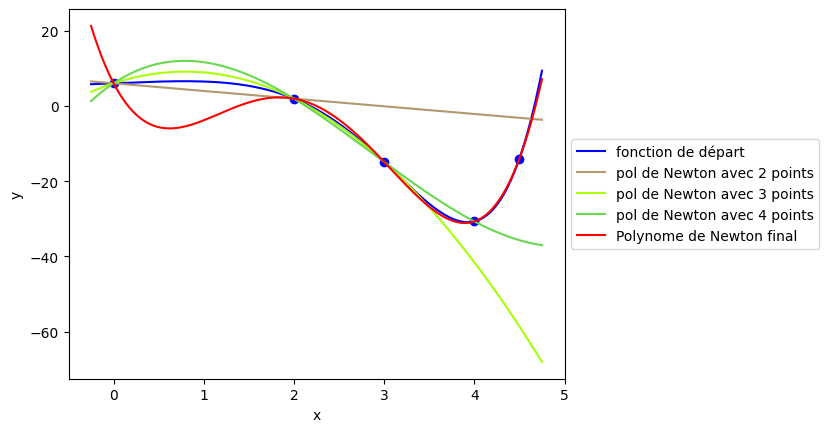

In [8]:
def pol_Newton(varX, X, Y):
    res = []
    
    for x in varX:
        item = Y[0]
        for i in range(1, len(X)):
            item += pol_ni(x, i, X, Y) * diffdiv(X[:i+1], Y[:i+1], i)
        res.append(item)
    return (res)

#tracé
plt.plot(xcont,ycont,label = "fonction de départ", color='blue')
plt.scatter(X,Y, color='blue')
varX=xcont
n=len(X)

for i in range(2,n):
    legend = "pol de Newton avec " +str(i)+" points"
    plt.plot(xcont,pol_Newton(xcont,X[:i],Y[:i]), label = legend, color=names_col[i])

#i = 3
#legend = "n" +str(i)
#plt.plot(xcont,pol_Newton(xcont,X[:i],Y[:i]),label = legend,color=names_col[i])    
plt.plot(xcont,pol_Newton(xcont,X,Y), label = "Polynome de Newton final", color='red')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Interpolation et regression

Attention, l'interpolation n'est pas (forcément) un bon outil pour la prédiction pour les sciences des données :


Premièrement l'interpolation demande de passer _exactement_ par les points
En effet, même si l'on a un contrôle assez précis de l'erreur, donnée par les points $(x_1,y_1), ..., (x_n,y_n)$, ce qui est rarement souhaitable pour une modélisation : mieux vaut souvent une droite de regression pertinente mais ne passant par aucun point mais expliquant bien les données (coût des moindres carrés faible) plutôt qu'un polynôme de degré $n$ passant par tous les points exactement. Ce phénomène est appelé _overfitting_  en machine learning.



Deuxièment, le polynôme interpolant n'est pas un bon outil de prédiction :


<div class="alert alert-block alert-info"><b>Proposition : erreur </b> 
    

Si  $f$ est $n+1$ fois différentiable sur $ I = [\min(x_i),\max(x_i)]$,  alors :
    $$\exists\xi \in I\quad f(x) - p_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^n (x-x_i)$$

</div>

il convient de remarquer que

- cette formule suppose que l'on connait bien $f$ (ce qui est toutefois souvent raisonnable)
- elle n'est valable que sur  $ I = [\min(x_i),\max(x_i)]$, on ne peut donc pas extrapoler au delà
- la valeur de $\xi$ est inconnue, seule son existence est prouvée




**question 5**

illustrer ce phénomène avec la fonction $f : x \mapsto \sin(x)$

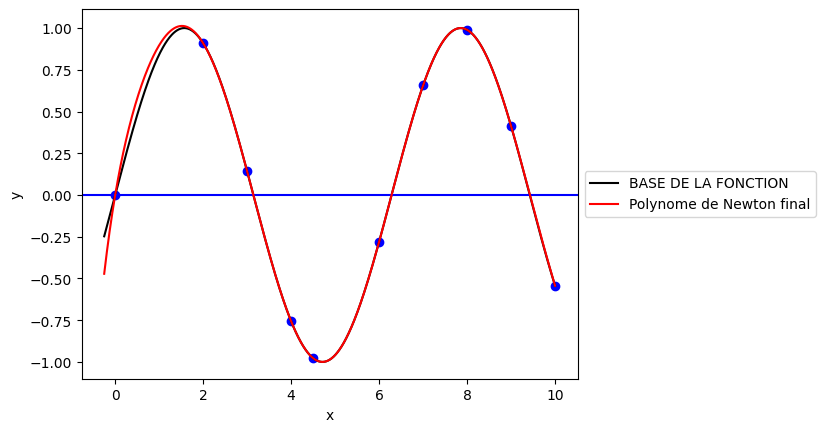

In [9]:
def f(x):
    return (np.sin(x))

X = [0, 2, 3, 4, 4.5, 6, 7, 8, 9, 10]
Y = f(X)
xcont = np.linspace(-.25, 10, 1000)
ycont = f(xcont)

plt.plot(xcont, ycont, label="BASE DE LA FONCTION", color='black')
plt.axhline(y=0.0, color='blue', linestyle='-')

plt.scatter(X, Y, color='blue')
n = len(X)
plt.plot(xcont, pol_Newton(xcont, X, Y),
         label="Polynome de Newton final", color='red')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Extensions suggérées :


#### explication des données et overfitting

Une manière d'utiliser l'interpolation comme un outil (naïf et imparfait) d'apprentissage d'IA est de partager les données entre données d'entrainement et données de validation (train et test). Si l'erreur $\sum_{test} (f(x_i) -y_i)^2 $ est faible alors on a un bon modèle.

Illustrer ce principe sur des exemples.

_remarque :_ même si l'interpolation n'est pas à proprement parler une méthode de machine learning, cette méthode d'analyse qualitative de l'approximation est centrale en apprentissage. 

#### phénomène de Runge

L'interpolation d'une fonction peut donner des résultats abhérents, ou toutefois déroutant.

Un exemple est le [phénomène de Runge](https://fr.wikipedia.org/wiki/Ph%C3%A9nom%C3%A8ne_de_Runge)

L'illustrer avec python, et des exemple ne provenant pas de wikipedia.

#### interpolation de Hermite

On peut essayer de construire une fonction qui ressemble à $f$ aux points $x_i$, mais aussi à $f'$. Cela conduit à [l'interpolation de Hermite](https://fr.wikipedia.org/wiki/Interpolation_d'Hermite)

L'illustrer avec python, et des exemple ne provenant pas de wikipedia.